# Particle level prediction using LSTM

Long Short Term Memory networks (LSTM), a type of Recurrent Neural Networks (RNN) and used for long-term dependencies, makes training on time series problems successful. They can search for trends in the data and predict relevant outputs. 

So, LSTM can be used for predicting pollution levels and related trends. By implementing LSTM here we can show how long-term trends can affect the forecast. The dataset used is the hourly data(for the period 2001-2018) of air pollution levels in Madrid.



### Data Reading

We use the records of station, `28079016`, active for the entire 18 years. But, not all particle was recorded for those 18 years. As such, we should carefully think about choosing the feature/particle for using in the model.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed
from keras.optimizers import RMSprop

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

sns.set()
%matplotlib inline

with pd.HDFStore('../input/air-quality-madrid/madrid.h5') as data:
    df = data['28079016']
    
df = df.sort_index()
df.info()

Using TensorFlow backend.


Opening ../input/air-quality-madrid/madrid.h5 in read-only mode
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 151776 entries, 2001-01-01 01:00:00 to 2018-05-01 00:00:00
Data columns (total 7 columns):
CO      151182 non-null float64
NO      64045 non-null float64
NO_2    151290 non-null float64
NOx     92321 non-null float64
O_3     151131 non-null float64
PM10    75920 non-null float64
SO_2    78497 non-null float64
dtypes: float64(7)
memory usage: 9.3 MB


In [3]:
print(df.shape)
df.head(10)

(151776, 7)


,CO,NO,NO_2,NOx,O_3,PM10,SO_2
date,,,,,,,
2001-01-01 01:00:00,0.59,NaN,46.560001,57.119999,8.610000,NaN,13.65
2001-01-01 02:00:00,1.09,NaN,52.369999,98.309998,5.640000,NaN,14.94
2001-01-01 03:00:00,1.37,NaN,53.910000,134.100006,5.450000,NaN,16.02
2001-01-01 04:00:00,1.45,NaN,53.320000,137.699997,5.460000,NaN,16.91
2001-01-01 05:00:00,0.94,NaN,53.860001,100.599998,7.040000,NaN,14.52
2001-01-01 06:00:00,0.58,NaN,42.810001,57.400002,16.660000,NaN,12.95
2001-01-01 07:00:00,0.45,NaN,34.750000,49.349998,26.709999,NaN,13.32
2001-01-01 08:00:00,0.46,NaN,40.380001,50.759998,22.870001,NaN,12.94
2001-01-01 09:00:00,0.49,NaN,39.419998,54.590000,27.770000,NaN,13.63


There are 7 particles(represented by 7 columns) that are hourly measured from 2001 to 2018 with 151776  entries. As we can see in the `missingno` plot(to visualize missing data), `CO`, `NO_2` and `O_3` have a lot of data available.So, these 3 features are the most promising for building our model.

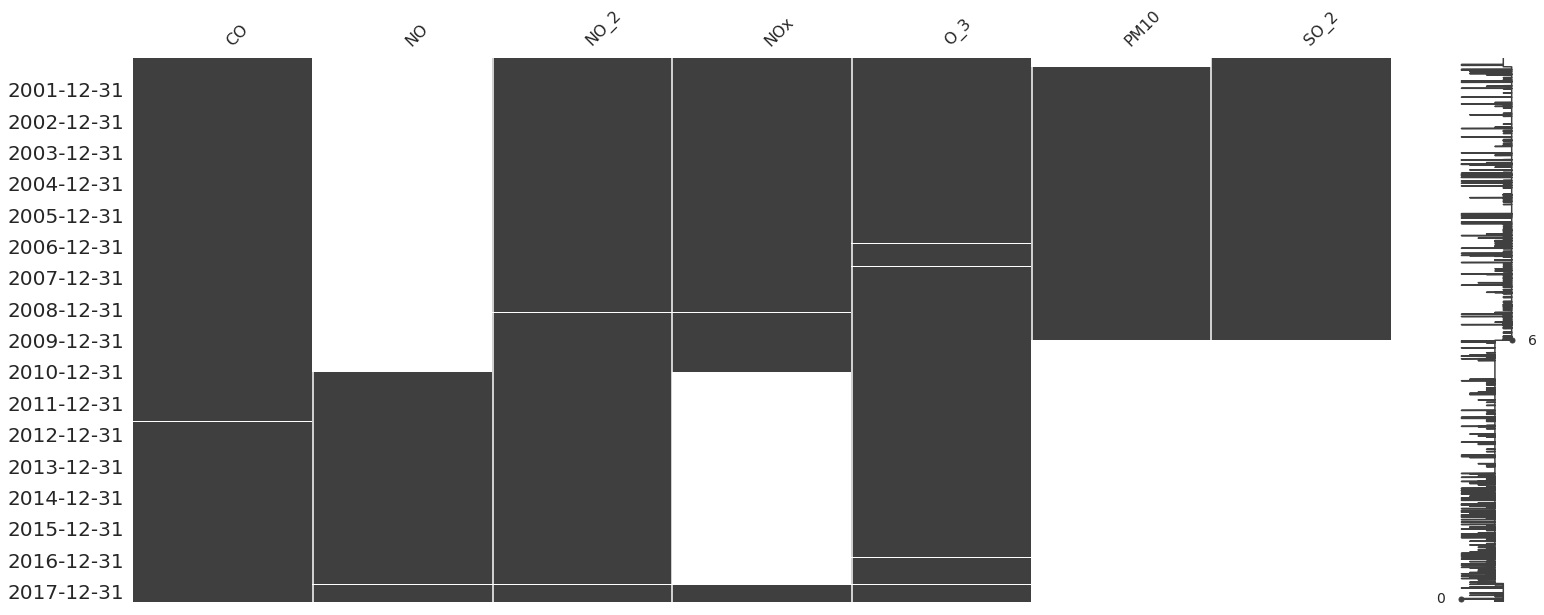

In [4]:
msno.matrix(df, freq='Y')

The interpolated series(below) for CO, NO_2, and O_3 shows that there is yearly seasonality in them, and `CO` has an inclination to decrease. Here, `NO_2` requires the least amount of data to be interpolated so we focus on this particle.

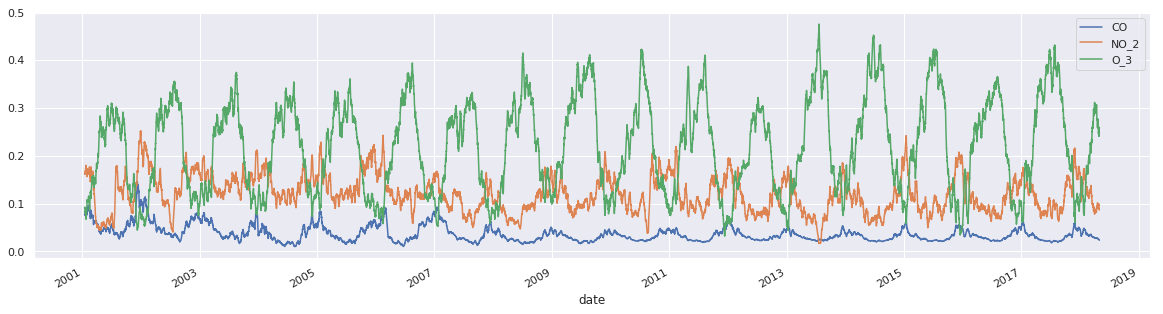

In [5]:
def interpolation_plot(df):
    fig, ax = plt.subplots(figsize=(20, 5))

    list_of_particles = ['CO', 'NO_2', 'O_3']

    particles_df = df[list_of_particles] 

    particles_df /= particles_df.max(axis=0)

    (particles_df.interpolate(method='time').rolling(window=24*15).mean().plot(ax=ax))

interpolation_plot(df)

### Preparing the Data

1. Apply natural logarithm to the data to smooth curve-variation for prediction and proper reconstruction.
2. The goal: Input 24 timesteps (i.e. one day with 24 hourly measurements) and predict the next 24 timesteps (the next day).
3. Pivot the next 48 hours for each sample into columns. Applying this to the whole dataset and choosing the rows with timestamps 12:00(midnight) and 00:00(noon), we get the following dataframe with samples having 50% overlap. This forces the data to be more general and generate twice as many examples.

In [6]:
def pivot_with_offset(pd_series, pd_offset):
    pivot = pd.DataFrame(index=df.index)

    for t in range(pd_offset * 2):
        pivot['t_{}'.format(t)] = pd_series.shift(-t)

    pivot = pivot.dropna(how='any')
    return pivot


offset = 24

NO_2_interpolated = df.NO_2.interpolate(method='time')
print(type(NO_2_interpolated))
print(NO_2_interpolated[:5])
pivoted_NO_2_interpolated = NO_2_interpolated.pipe(pivot_with_offset, offset)
print(type(pivoted_NO_2_interpolated))
pivoted_NO_2_interpolated.head()



<class 'pandas.core.series.Series'>
date
2001-01-01 01:00:00    46.560001
2001-01-01 02:00:00    52.369999
2001-01-01 03:00:00    53.910000
2001-01-01 04:00:00    53.320000
2001-01-01 05:00:00    53.860001
Name: NO_2, dtype: float64
<class 'pandas.core.frame.DataFrame'>


,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,t_40,t_41,t_42,t_43,t_44,t_45,t_46,t_47
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 01:00:00,46.560001,52.369999,53.910000,53.320000,53.860001,42.810001,34.750000,40.380001,39.419998,34.490002,27.840000,24.930000,30.190001,40.340000,54.939999,46.709999,40.110001,58.959999,66.529999,58.919998,71.029999,59.610001,51.139999,35.490002,23.35,24.84,15.84,13.22,8.950000,22.990000,38.770000,59.910000,72.110001,71.919998,65.769997,58.130001,43.810001,40.380001,38.980000,41.220001,49.160000,61.500000,72.050003,80.480003,69.309998,74.510002,70.180000,55.759998
2001-01-01 02:00:00,52.369999,53.910000,53.320000,53.860001,42.810001,34.750000,40.380001,39.419998,34.490002,27.840000,24.930000,30.190001,40.340000,54.939999,46.709999,40.110001,58.959999,66.529999,58.919998,71.029999,59.610001,51.139999,35.490002,23.350000,24.84,15.84,13.22,8.95,22.990000,38.770000,59.910000,72.110001,71.919998,65.769997,58.130001,43.810001,40.380001,38.980000,41.220001,49.160000,61.500000,72.050003,80.480003,69.309998,74.510002,70.180000,55.759998,34.480000
2001-01-01 03:00:00,53.910000,53.320000,53.860001,42.810001,34.750000,40.380001,39.419998,34.490002,27.840000,24.930000,30.190001,40.340000,54.939999,46.709999,40.110001,58.959999,66.529999,58.919998,71.029999,59.610001,51.139999,35.490002,23.350000,24.840000,15.84,13.22,8.95,22.99,38.770000,59.910000,72.110001,71.919998,65.769997,58.130001,43.810001,40.380001,38.980000,41.220001,49.160000,61.500000,72.050003,80.480003,69.309998,74.510002,70.180000,55.759998,34.480000,26.410000
2001-01-01 04:00:00,53.320000,53.860001,42.810001,34.750000,40.380001,39.419998,34.490002,27.840000,24.930000,30.190001,40.340000,54.939999,46.709999,40.110001,58.959999,66.529999,58.919998,71.029999,59.610001,51.139999,35.490002,23.350000,24.840000,15.840000,13.22,8.95,22.99,38.77,59.910000,72.110001,71.919998,65.769997,58.130001,43.810001,40.380001,38.980000,41.220001,49.160000,61.500000,72.050003,80.480003,69.309998,74.510002,70.180000,55.759998,34.480000,26.410000,19.080000
2001-01-01 05:00:00,53.860001,42.810001,34.750000,40.380001,39.419998,34.490002,27.840000,24.930000,30.190001,40.340000,54.939999,46.709999,40.110001,58.959999,66.529999,58.919998,71.029999,59.610001,51.139999,35.490002,23.350000,24.840000,15.840000,13.220000,8.95,22.99,38.77,59.91,72.110001,71.919998,65.769997,58.130001,43.810001,40.380001,38.980000,41.220001,49.160000,61.500000,72.050003,80.480003,69.309998,74.510002,70.180000,55.759998,34.480000,26.410000,19.080000,18.350000


In [7]:
log_pivoted_NO_2_interpolated = pivoted_NO_2_interpolated.apply(np.log, axis=1)
final_pivot_table = (log_pivoted_NO_2_interpolated.replace(-np.inf))

# Get the timestamps at 00:00 and 12:00
final_pivot_table = final_pivot_table[(final_pivot_table.index.hour % 12) == 0]

# Make it a multiple of the batch_size
if final_pivot_table.shape[0] % 32 != 0:
    final_pivot_table = final_pivot_table.iloc[:-(final_pivot_table.shape[0]%32)]

print(final_pivot_table.shape)
print(type(final_pivot_table))
final_pivot_table.head()

(12640, 48)
<class 'pandas.core.frame.DataFrame'>


,t_0,t_1,t_2,t_3,t_4,t_5,t_6,t_7,t_8,t_9,t_10,t_11,t_12,t_13,t_14,t_15,t_16,t_17,t_18,t_19,t_20,t_21,t_22,t_23,t_24,t_25,t_26,t_27,t_28,t_29,t_30,t_31,t_32,t_33,t_34,t_35,t_36,t_37,t_38,t_39,t_40,t_41,t_42,t_43,t_44,t_45,t_46,t_47
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2001-01-01 12:00:00,3.216072,3.407511,3.697344,4.006242,3.843958,3.691626,4.076859,4.197653,4.076181,4.263102,4.087823,3.934567,3.569251,3.150597,3.212455,2.762538,2.581731,2.191654,3.135059,3.657647,4.092843,4.278193,4.275554,4.186164,4.062682,3.779862,3.698335,3.663049,3.718924,3.895080,4.119037,4.277360,4.388009,4.238589,4.310933,4.251063,4.021057,3.540379,3.273743,2.948641,2.909630,3.004196,3.119718,3.896503,4.185860,4.197052,4.335459,4.260283
2001-01-02 00:00:00,3.569251,3.150597,3.212455,2.762538,2.581731,2.191654,3.135059,3.657647,4.092843,4.278193,4.275554,4.186164,4.062682,3.779862,3.698335,3.663049,3.718924,3.895080,4.119037,4.277360,4.388009,4.238589,4.310933,4.251063,4.021057,3.540379,3.273743,2.948641,2.909630,3.004196,3.119718,3.896503,4.185860,4.197052,4.335459,4.260283,4.235265,4.254051,4.299596,4.126489,4.198705,4.315887,4.363735,4.406475,4.418961,4.458525,4.354270,4.079062
2001-01-02 12:00:00,4.062682,3.779862,3.698335,3.663049,3.718924,3.895080,4.119037,4.277360,4.388009,4.238589,4.310933,4.251063,4.021057,3.540379,3.273743,2.948641,2.909630,3.004196,3.119718,3.896503,4.185860,4.197052,4.335459,4.260283,4.235265,4.254051,4.299596,4.126489,4.198705,4.315887,4.363735,4.406475,4.418961,4.458525,4.354270,4.079062,3.971800,3.820127,3.702042,3.286908,3.308351,2.676903,2.446685,3.441699,4.141069,4.340553,4.183423,4.144404
2001-01-03 00:00:00,4.021057,3.540379,3.273743,2.948641,2.909630,3.004196,3.119718,3.896503,4.185860,4.197052,4.335459,4.260283,4.235265,4.254051,4.299596,4.126489,4.198705,4.315887,4.363735,4.406475,4.418961,4.458525,4.354270,4.079062,3.971800,3.820127,3.702042,3.286908,3.308351,2.676903,2.446685,3.441699,4.141069,4.340553,4.183423,4.144404,3.988428,3.980429,4.133886,4.098005,3.916015,4.041295,4.278331,4.431412,4.437934,4.554613,4.394079,4.366024
2001-01-03 12:00:00,4.235265,4.254051,4.299596,4.126489,4.198705,4.315887,4.363735,4.406475,4.418961,4.458525,4.354270,4.079062,3.971800,3.820127,3.702042,3.286908,3.308351,2.676903,2.446685,3.441699,4.141069,4.340553,4.183423,4.144404,3.988428,3.980429,4.133886,4.098005,3.916015,4.041295,4.278331,4.431412,4.437934,4.554613,4.394079,4.366024,4.322011,4.152928,3.887115,3.447126,3.572627,3.766997,3.854182,4.028205,4.021057,4.099000,4.248495,4.260847


Let's split the series into features and labels. In each row, the first 24 hours are the features (`X`) to be used in training and inference. The next 24 hours are levels to predict (`y`). 20% of the data are kept for testing.

In [8]:

def create_train_test_data(data, test_split_ratio):
    split_at_pt = int(data.shape[0] * (1 - test_split_ratio))
    split_at_pt -= split_at_pt % 32

    np_series = data.values #final_pivot_table

    X_train = data.values[:split_at_pt , :offset]
    y_train = data.values[:split_at_pt, offset:]
    X_test = data.values[split_at_pt:, :offset]
    y_test = data.values[split_at_pt:, offset:]
    return X_train, X_test, y_train, y_test

test_split_ratio = 0.2

X_train, X_test, y_train, y_test = create_train_test_data(final_pivot_table, test_split_ratio)

    

In [9]:
print(y_train.shape)
print(type(y_train))
y_train[:10]

(10112, 24)
<class 'numpy.ndarray'>


array([[4.0626819 , 3.77986213, 3.69833464, 3.66304868, 3.71892361,
        3.89508028, 4.11903717, 4.27736036, 4.38800875, 4.23858916,
        4.31093337, 4.25106337, 4.02105674, 3.54037943, 3.27374272,
        2.94864066, 2.9096296 , 3.00419636, 3.11971823, 3.89650318,
        4.18585967, 4.19705153, 4.33545901, 4.26028267],
       [4.02105674, 3.54037943, 3.27374272, 2.94864066, 2.9096296 ,
        3.00419636, 3.11971823, 3.89650318, 4.18585967, 4.19705153,
        4.33545901, 4.26028267, 4.23526528, 4.2540512 , 4.29959564,
        4.126489  , 4.19870455, 4.3158868 , 4.3637354 , 4.40647536,
        4.41896111, 4.45852461, 4.35426993, 4.07906171],
       [4.23526528, 4.2540512 , 4.29959564, 4.126489  , 4.19870455,
        4.3158868 , 4.3637354 , 4.40647536, 4.41896111, 4.45852461,
        4.35426993, 4.07906171, 3.97180024, 3.820127  , 3.70204241,
        3.28690824, 3.30835084, 2.67690347, 2.44668545, 3.44169932,
        4.14106909, 4.34055339, 4.18342319, 4.14440379],
       [3.971

 We scale the data in the interval [0, 1] because machine learning models perform better with normalized attributes. 

In [10]:
def scale_array(arr, lift, scale):
    return (arr - lift) / scale

def scaling_data(X_train, X_test, y_train, y_test):
    
    min_val = X_train.min() #lift
    max_val = X_train.max() #scale
    X_train = np.expand_dims(scale_array(X_train, min_val, max_val), axis=2)
    y_train = np.expand_dims(scale_array(y_train, min_val, max_val), axis=2)
    X_test = np.expand_dims(scale_array(X_test, min_val, max_val), axis=2)
    y_test = np.expand_dims(scale_array(y_test, min_val, max_val), axis=2)
    
    return  X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = scaling_data(X_train, X_test, y_train, y_test)
X_train.shape

(10112, 24, 1)

### Training Model

We add 2 `LSTM` layers and a `TimeDistributed` - `Dense` layer for predicting the 24 target timestamps. The optimizer is `RMSprop` and the loss function is mean squared error.

In [20]:
def generate_model(offset, neurons=(2,1), batch_size=32, lr=0.005, n_features=1):
    model = Sequential()
    
    # First LSTM layer
    model.add(LSTM(
        neurons[0], return_sequences=True, stateful=True, 
        batch_input_shape=(batch_size, offset, n_features))
    )
    
    
    # Second LSTM layer if defined
    if neurons[1]:
        model.add(LSTM(
            neurons[1], return_sequences=True, stateful=True, 
            batch_input_shape=(batch_size, offset, n_features))
        )
    
    # TimeDistributed layer to generate all the timesteps
    model.add(TimeDistributed(Dense(1)))
    
    optimizer = RMSprop(lr=lr)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    
    return model

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    model.reset_states()
    result = np.mean((y_test - predictions) ** 2)
    return result


def training_phase(model, X_train, y_train, X_test, y_test, batch_size=32, epochs=20):
    mean_squared_errors_train = list()
    mean_sqaured_errors_test = list()

    for i in range(epochs):

        print('Epoch {:02d}/{}...'.format(i + 1, epochs), end=' ')

        log = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=0, shuffle=False)
    
        mean_squared_errors_train.append(log.history['loss'][-1])
        print('train loss: {:.4f}'.format(mean_squared_errors_train[-1]))
        mean_sqaured_errors_test.append(evaluate_model(model, X_test, y_test))
        print('test loss: {:.4f}'.format(mean_sqaured_errors_test[-1]))
        
    
        '''
        Since the model is stateful, we want to reset the state of the network after each epoch. 
        This does not erase the weights learned, instead it just resets the state to be fed via the context neurons. 
        '''
        model.reset_states() 
        
    return model, mean_squared_errors_train, mean_sqaured_errors_test




model = generate_model(offset)
model, train_mse, test_mse = training_phase(model, X_train, y_train, X_test, y_test ,epochs =20)

'''
model.fit(
    X_train, y_train, 
    epochs=1, batch_size=32, 
    verbose=1, shuffle=False
)
model.reset_states()

preds = model.predict(X_test)
'''

#'MSE: {:.5f}'.format(evaluate_model(model, X_test, y_test))

Epoch 01/20... train loss: 0.0313
test loss: 0.0155
Epoch 02/20... train loss: 0.0126
test loss: 0.0141
Epoch 03/20... train loss: 0.0117
test loss: 0.0136
Epoch 04/20... train loss: 0.0113
test loss: 0.0132
Epoch 05/20... train loss: 0.0110
test loss: 0.0130
Epoch 06/20... train loss: 0.0108
test loss: 0.0128
Epoch 07/20... train loss: 0.0107
test loss: 0.0127
Epoch 08/20... train loss: 0.0106
test loss: 0.0126
Epoch 09/20... train loss: 0.0106
test loss: 0.0125
Epoch 10/20... train loss: 0.0106
test loss: 0.0125
Epoch 11/20... train loss: 0.0106
test loss: 0.0125
Epoch 12/20... train loss: 0.0106
test loss: 0.0125
Epoch 13/20... train loss: 0.0106
test loss: 0.0125
Epoch 14/20... train loss: 0.0106
test loss: 0.0125
Epoch 15/20... train loss: 0.0106
test loss: 0.0125
Epoch 16/20... train loss: 0.0106
test loss: 0.0125
Epoch 17/20... train loss: 0.0106
test loss: 0.0125
Epoch 18/20... train loss: 0.0106
test loss: 0.0125
Epoch 19/20... train loss: 0.0106
test loss: 0.0125
Epoch 20/20.

'\nmodel.fit(\n    X_train, y_train, \n    epochs=1, batch_size=32, \n    verbose=1, shuffle=False\n)\nmodel.reset_states()\n\npreds = model.predict(X_test)\n'

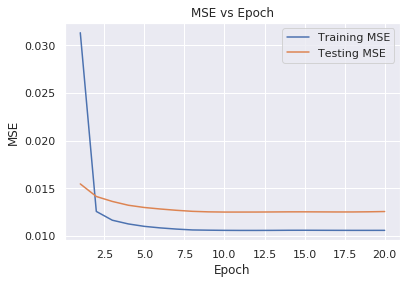

In [33]:
# line 1 points
y1 = train_mse
x1 = [(i+1) for i in range(20)]
# plotting the line 1 points 
plt.plot(x1, y1, label = "Training MSE")
# line 2 points
y2 = test_mse
x2 =  [(i+1) for i in range(20)]
# plotting the line 2 points 
plt.plot(x2, y2, label = "Testing MSE")
plt.xlabel('Epoch')
# Set the y axis label of the current axis.
plt.ylabel('MSE')
# Set a title of the current axes.
plt.title('MSE vs Epoch')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

Looking at the MSE plot, we see the errors become somewhat stable after epoch 10, with train and test errors maintaining similar difference. 

Seeing the results, a few neurons and a lot of epochs is a good way to approach the problem. A plot of test data and predictions for two weeks shows,the network has potential, but has room for improvement. The issue is the prediction fails in scale and it's rather linear, though some peaks are accurately predicted.



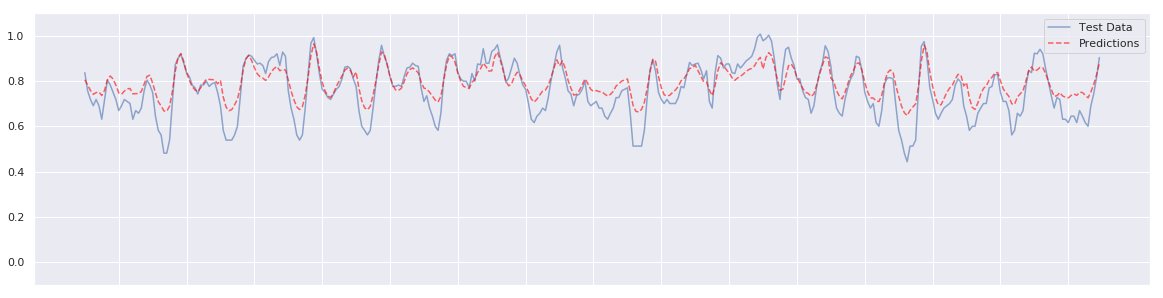

In [30]:
def plot_prediction_test(model):
    predictions = model.predict(X_test)
    fig, ax = plt.subplots(figsize=(20, 5))

    start = X_test.shape[0] - 42
    interval = X_test[start+3:start+33:2, :, 0].reshape(-1, 1)
    pred_interval = predictions[start+3:start+33:2, :, 0].reshape(-1, 1)
    #interval = X_test[:, :, 0].reshape(-1, 1)
    #pred_interval = predictions[:, :, 0].reshape(-1, 1)

    truth, = plt.plot(np.arange(24*15), interval, alpha=0.6)
    pred, = plt.plot(np.arange(24*15), pred_interval,alpha=0.6,linestyle='--', color='red' )


    plt.legend( [truth, pred], ['Test Data', 'Predictions'])
    ax.set_ylim([-.1, 1.1])
    ax.set_xticks(12 + np.arange(15) * offset)
    _ = ax.set_xticklabels([])
    
plot_prediction_test(model)